# Importing Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import root_mean_squared_error,r2_score 
import lightgbm as lgb
import xgboost as xgb
import os

import warnings
warnings.filterwarnings('ignore')

# Load PreProcessed Data

In [9]:
df_train = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\PreProcessed Data\Preprocessed_Train.csv')
df_val = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\PreProcessed Data\Preprocessed_Val.csv')
df_test = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Sales Forecasting Description\PreProcessed Data\Preprocessed_Test.csv')

In [10]:
x_train = df_train.drop(columns=['Weekly_Sales'])
y_train = df_train['Weekly_Sales']
x_val = df_val.drop(columns=['Weekly_Sales'])
y_val = df_val['Weekly_Sales']
x_test = df_test

# Feature Selection

In [11]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337256 entries, 0 to 337255
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Store                          337256 non-null  float64
 1   Dept                           337256 non-null  float64
 2   IsHoliday                      337256 non-null  int64  
 3   Temperature                    337256 non-null  float64
 4   Fuel_Price                     337256 non-null  float64
 5   CPI                            337256 non-null  float64
 6   Unemployment                   337256 non-null  float64
 7   Type                           337256 non-null  int64  
 8   Size                           337256 non-null  float64
 9   Year                           337256 non-null  int64  
 10  Month                          337256 non-null  int64  
 11  Week                           337256 non-null  int64  
 12  Day                           

In [12]:
# Manually selected featurees
selected_features = [
    'Store', 'Dept', 'Week', 'Month', 'Quarter', 'DayOfWeek', 'DaysToHoliday',
    'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Type', 'Size', 'MarkDown_Total',
    'Historical_Avg_Temperature', 'Historical_Avg_Fuel_Price', 'Historical_Avg_MarkDown_Total',
    'FuelPrice_Change', 'Temperature_Change', 'Prev_IsHoliday', 'Prev_Temperature', 'Prev_MarkDown',
    'Temperature_Rolling12', 'FuelPrice_Rolling12', 'MarkDown_Rolling12', 'Temperature_Rolling52', 'MarkDown_Rolling52'
]

In [13]:
# Selecting features using SelectKBest for regression
selector = SelectKBest(score_func=mutual_info_regression, k=25)
selector.fit(x_train, y_train)
selected_features_kbest = x_train.columns[selector.get_support().tolist()]
print("SelectKBest:", selected_features_kbest)

SelectKBest: Index(['Store', 'Dept', 'CPI', 'Unemployment', 'Type', 'Size',
       'Historical_Avg_Temperature', 'Historical_Avg_Fuel_Price',
       'Historical_Avg_MarkDown_Total', 'Historical_Avg_CPI',
       'Historical_Avg_Unemployment', 'Prev_Temperature',
       'Temperature_Rolling4', 'FuelPrice_Rolling4', 'Temperature_Rolling8',
       'FuelPrice_Rolling8', 'Temperature_Rolling12', 'FuelPrice_Rolling12',
       'MarkDown_Rolling12', 'Temperature_Rolling26', 'FuelPrice_Rolling26',
       'MarkDown_Rolling26', 'Temperature_Rolling52', 'FuelPrice_Rolling52',
       'MarkDown_Rolling52'],
      dtype='object')


In [14]:
# Feature selection using RFE with a regression estimator
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=25)
rfe.fit(x_train, y_train)
selected_features_rfe = x_train.columns[rfe.support_]
print("RFE selected features:", selected_features_rfe.tolist())

RFE selected features: ['Store', 'Dept', 'IsHoliday', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Year', 'Month', 'Week', 'Day', 'Quarter', 'DaysToHoliday', 'Historical_Avg_Temperature', 'Historical_Avg_Fuel_Price', 'Historical_Avg_CPI', 'Historical_Avg_Unemployment', 'FuelPrice_Change', 'Prev_IsHoliday', 'FuelPrice_Rolling4', 'FuelPrice_Rolling8', 'Temperature_Rolling12', 'FuelPrice_Rolling26', 'Temperature_Rolling52', 'FuelPrice_Rolling52']


# Model Development

In [17]:
feature_sets = {
    'manual': selected_features,
    'kbest': selected_features_kbest.tolist(),
    'rfe': selected_features_rfe.tolist(),
    'all': x_train.columns.tolist()
}

## LightGBM Model

### Train the model 

In [18]:
# Dictionaries to store results and models
lgb_results = {}
lgb_models = {}

# Time-aware cross-validation on training set only
tscv = TimeSeriesSplit(n_splits=3)

for name, features in feature_sets.items():
    
    # Select features from time-sorted splits
    X_train_selected = x_train[features]
    X_val_selected = x_val[features]
    X_test_selected = x_test[features]  

    # Initialize LightGBM Regressor
    lgb_model = lgb.LGBMRegressor(
        random_state=42,
        force_col_wise=True,
        verbosity=-1,
        n_jobs=-1
    )

    # Hyperparameter grid
    lgb_params = {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, -1],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0]
    }

    # Randomized Search using time-aware CV
    lgb_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=lgb_params,
        n_iter=10,
        cv=tscv, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # Fit hyperparameter tuning on training set
    lgb_search.fit(X_train_selected, y_train)
    lgb_best = lgb_search.best_estimator_

    # Predictions on training and holdout validation sets
    y_train_pred = lgb_best.predict(X_train_selected)
    y_val_pred = lgb_best.predict(X_val_selected)

    # Metrics
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Store results
    lgb_results[name] = {
        'lgbm_best_params': lgb_search.best_params_,
        'lgbm_train_rmse': train_rmse,
        'lgbm_val_rmse': val_rmse,
        'lgbm_train_r2': train_r2,
        'lgbm_val_r2': val_r2
    }

    # Save best model
    lgb_models[name] = lgb_best
    print(f"Feature Set: {name} done")

Feature Set: manual done
Feature Set: kbest done
Feature Set: rfe done
Feature Set: all done


In [19]:
# Convert results dictionary to DataFrame
lgb_results_df = pd.DataFrame.from_dict(lgb_results, orient='index')

# Display comparison
print("Model Performance Comparison (LightGBM):")
print("=" * 50)

for feature_set in lgb_results_df.index:
    print(f"\nFeature Set: {feature_set}")

    # Training 
    train_r2 = lgb_results_df.loc[feature_set, 'lgbm_train_r2']
    train_rmse = lgb_results_df.loc[feature_set, 'lgbm_train_rmse']
    print(f" Train R²:   {train_r2:.4f}")
    print(f" Train RMSE: {train_rmse:,.2f}")

    # Validation
    val_r2 = lgb_results_df.loc[feature_set, 'lgbm_val_r2']
    val_rmse = lgb_results_df.loc[feature_set, 'lgbm_val_rmse']
    print(f" Val R²:     {val_r2:.4f}")
    print(f" Val RMSE:   {val_rmse:,.2f}")

Model Performance Comparison (LightGBM):

Feature Set: manual
 Train R²:   0.9673
 Train RMSE: 4,137.81
 Val R²:     0.9597
 Val RMSE:   4,406.48

Feature Set: kbest
 Train R²:   0.9377
 Train RMSE: 5,715.30
 Val R²:     0.9362
 Val RMSE:   5,544.41

Feature Set: rfe
 Train R²:   0.9632
 Train RMSE: 4,391.37
 Val R²:     0.9567
 Val RMSE:   4,568.02

Feature Set: all
 Train R²:   0.9692
 Train RMSE: 4,021.13
 Val R²:     0.9603
 Val RMSE:   4,371.43


### Predict the y_test using the best LightGBM Model 

In [20]:
# Predict for your best feature set
best_set_name = 'manual'  
features = feature_sets[best_set_name]
X_test_selected = x_test[features]

# predict using the best LightGBM model
best_model = lgb_models[best_set_name]
lgb_predictions = best_model.predict(X_test_selected)

print("LightGBM predictions done.")

LightGBM predictions done.


## XGBoost Model

### Train the Model

In [21]:
# Dictionaries to store results and models
xgb_results = {}
xgb_models = {}

# Time-aware cross-validation on training set 
tscv = TimeSeriesSplit(n_splits=3)

for name, features in feature_sets.items():
    
    # Select features
    X_train_selected = x_train[features]
    X_val_selected = x_val[features]
    X_test_selected = x_test[features]  
    
    # Initialize XGBoost Regressor
    xgb_model = xgb.XGBRegressor(
        random_state=42,
        tree_method='hist',
        verbosity=0,
        n_jobs=-1
    )

    # Hyperparameter grid
    xgb_params = {
        'n_estimators': [200, 500],              
        'max_depth': [3, 5],                     
        'learning_rate': [0.01, 0.05],          
        'subsample': [0.7, 0.8],                 
        'colsample_bytree': [0.7, 0.8],          
        'gamma': [1, 5],                        
        'reg_alpha': [0.1, 1, 5],               
        'reg_lambda': [1, 5, 10],               
        'min_child_weight': [3, 5],             
    }

    # Randomized search with time-aware CV
    xgb_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=xgb_params,
        n_iter=10,
        cv=tscv, 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # Fit on training data 
    xgb_search.fit(X_train_selected, y_train)
    xgb_best = xgb_search.best_estimator_

    # Predictions on train and validation
    y_train_pred = xgb_best.predict(X_train_selected)
    y_val_pred = xgb_best.predict(X_val_selected)

    # Metrics
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    val_rmse = root_mean_squared_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    # Store results
    xgb_results[name] = {
        'xgb_best_params': xgb_search.best_params_,
        'xgb_train_rmse': round(train_rmse, 2),
        'xgb_val_rmse': round(val_rmse, 2),
        'xgb_train_r2': round(train_r2, 4),
        'xgb_val_r2': round(val_r2, 4)
    }

    # Save the trained model
    xgb_models[name] = xgb_best
    print(f"Feature Set: {name} done")

Feature Set: manual done
Feature Set: kbest done
Feature Set: rfe done
Feature Set: all done


In [23]:
# Convert results dictionary to DataFrame
xgb_results_df = pd.DataFrame.from_dict(xgb_results, orient='index')

# Display comparison
print("Model Performance Comparison (XGBoost):")
print("=" * 50)

for feature_set in xgb_results_df.index:
    print(f"\nFeature Set: {feature_set}")

    # Training metrics
    train_r2 = xgb_results_df.loc[feature_set, 'xgb_train_r2']
    train_rmse = xgb_results_df.loc[feature_set, 'xgb_train_rmse']
    print(f" Train R²:   {train_r2:.4f}")
    print(f" Train RMSE: {train_rmse:,.2f}")

    # Validation metrics
    val_r2 = xgb_results_df.loc[feature_set, 'xgb_val_r2']
    val_rmse = xgb_results_df.loc[feature_set, 'xgb_val_rmse']
    print(f" Val R²:     {val_r2:.4f}")
    print(f" Val RMSE:   {val_rmse:,.2f}")

Model Performance Comparison (XGBoost):

Feature Set: manual
 Train R²:   0.9216
 Train RMSE: 6,410.89
 Val R²:     0.9301
 Val RMSE:   5,804.13

Feature Set: kbest
 Train R²:   0.8955
 Train RMSE: 7,402.80
 Val R²:     0.9217
 Val RMSE:   6,139.64

Feature Set: rfe
 Train R²:   0.9026
 Train RMSE: 7,144.97
 Val R²:     0.9170
 Val RMSE:   6,321.51

Feature Set: all
 Train R²:   0.9202
 Train RMSE: 6,469.08
 Val R²:     0.9309
 Val RMSE:   5,769.54


### Predict the y_test using the best XGBoost Model 

In [24]:
# Predict using the best XGBoost model for the selected feature set
best_set_name = 'manual'  
features = feature_sets[best_set_name]
X_test_selected = x_test[features]

# Retrieve the best XGBoost model 
best_model = xgb_models[best_set_name]  
xgb_predictions = best_model.predict(X_test_selected)

print("XGBoost predictions done")

XGBoost predictions done


## Save Both Models prediction into an excel sheet

In [26]:
output_folder = 'Predictions'
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, 'Weekly_Sales_Prediction.xlsx') 

# prediction dataframes
df_lgb = pd.DataFrame({
    'ID': x_test.index if hasattr(x_test, 'index') else range(len(lgb_predictions)),
    'prediction': lgb_predictions
})

df_xgb = pd.DataFrame({
    'ID': x_test.index if hasattr(x_test, 'index') else range(len(xgb_predictions)),
    'prediction': xgb_predictions
})

# write to excel with two sheets
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    df_lgb.to_excel(writer, sheet_name='LightGBM', index=False)
    df_xgb.to_excel(writer, sheet_name='XGBoost', index=False)

print(f"Predictions saved to {output_file}")

Predictions saved to Predictions\Weekly_Sales_Prediction.xlsx


# Compare the Performance of Both Models

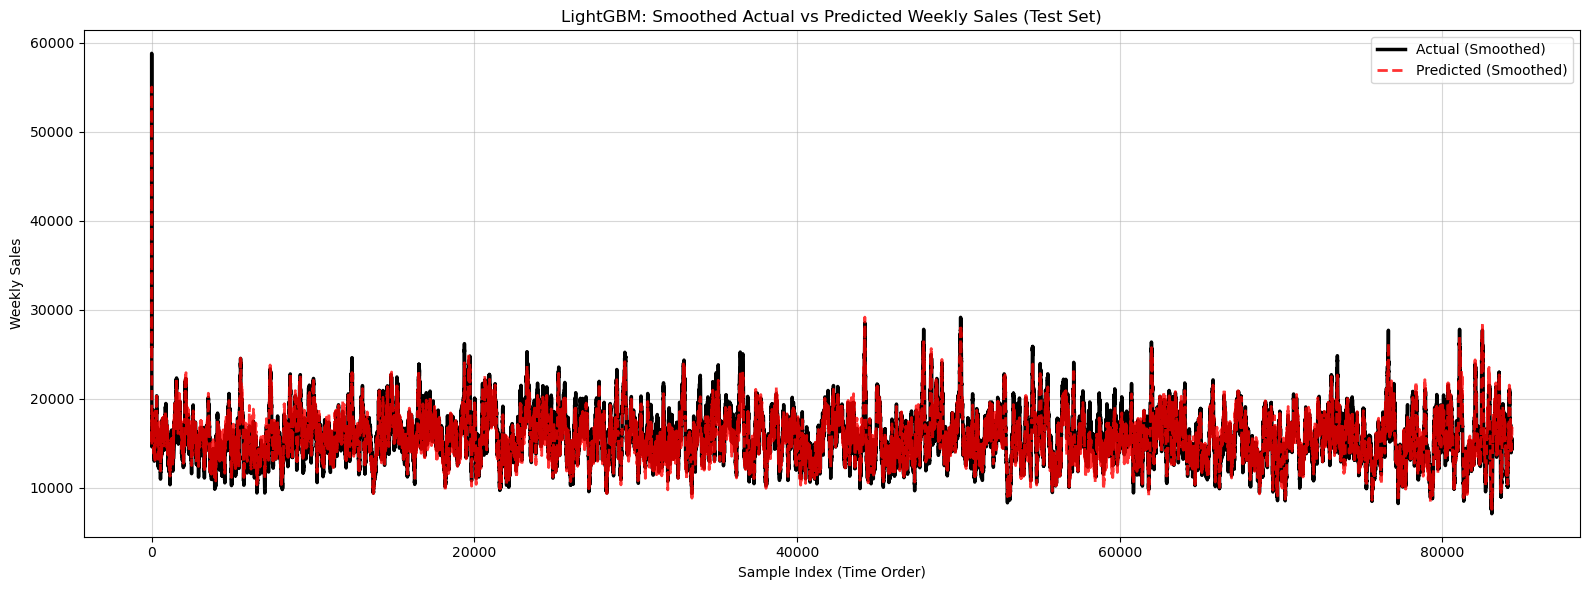

In [ ]:
# Plotting Actual vs Predicted for the best LightGBM model over time
X_test_selected = x_test[features]
best_model = lgb_models[best_set_name]
lgb_test_pred = best_model.predict(X_test_selected)

# Create DataFrame to align actual and predicted for validation set
df_plot = pd.DataFrame({
    'actual': y_val.values,
    'predicted': y_val_pred
})

# Smooth using rolling mean 
df_plot_smooth = df_plot.rolling(window=100, min_periods=1).mean()

# Plot smoothed actual vs predicted
plt.figure(figsize=(16,6))
plt.plot(df_plot_smooth['actual'],  label='Actual (Smoothed)',color='black', linewidth=2.5)

plt.plot(df_plot_smooth['predicted'], label='Predicted (Smoothed)',color='red',linewidth=2,alpha=0.8, linestyle='--')    

plt.title('LightGBM: Smoothed Actual vs Predicted Weekly Sales ')
plt.xlabel('Time Order')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.5)  
plt.tight_layout()
plt.show()

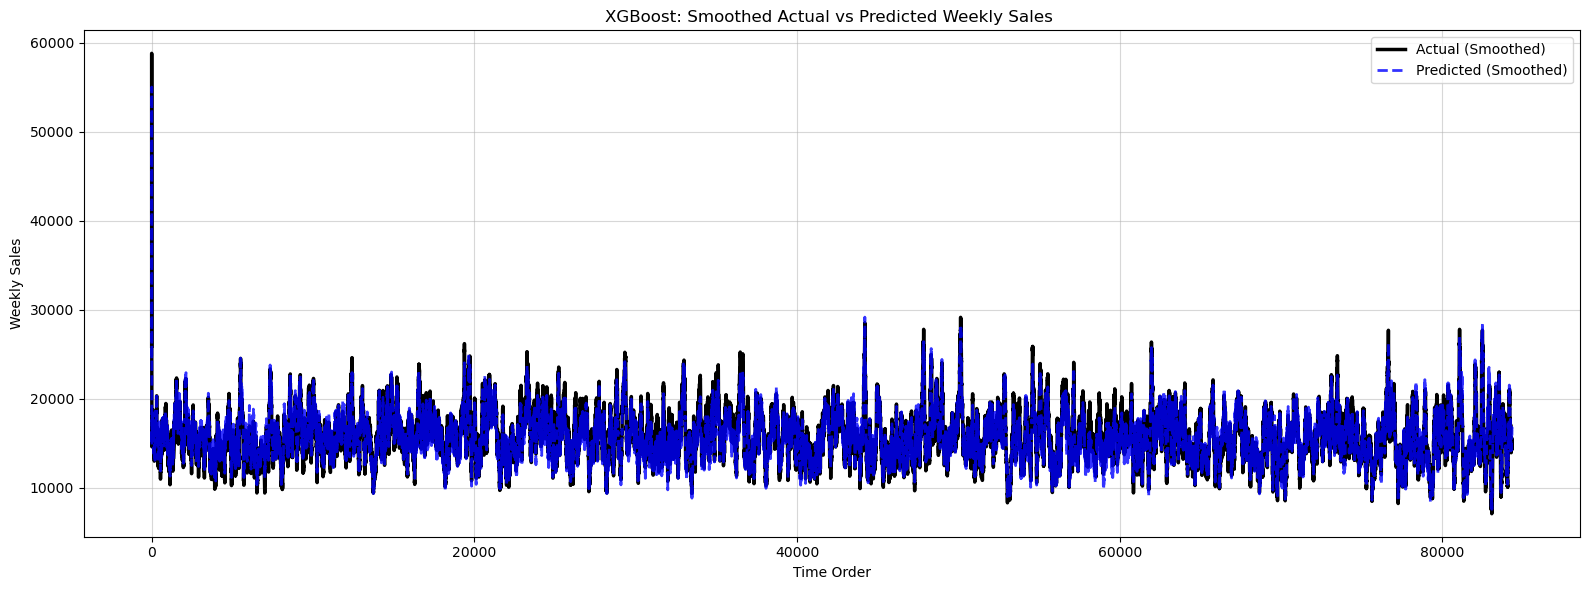

In [39]:
# Plotting Actual vs Predicted for the best XGBoost model over time

# Create DataFrame to align actual and predicted
df_plot_xgb = pd.DataFrame({
    'actual': y_val.values,
    'predicted': y_val_pred
})

# Smooth using rolling mean
df_plot_xgb_smooth = df_plot_xgb.rolling(window=100, min_periods=1).mean()

# Plot smoothed actual vs predicted for XGBoost
plt.figure(figsize=(16,6))
plt.plot(df_plot_xgb_smooth['actual'],label='Actual (Smoothed)',color='black',linewidth=2.5)

plt.plot(df_plot_xgb_smooth['predicted'],label='Predicted (Smoothed)', color='blue', linewidth=2, alpha=0.8,linestyle='--')

plt.title('XGBoost: Smoothed Actual vs Predicted Weekly Sales ')
plt.xlabel('Time Order')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


In [40]:
lgb_results_df = lgb_results_df.reset_index().rename(columns={'index': 'Feature_Set'})
xgb_results_df = xgb_results_df.reset_index().rename(columns={'index': 'Feature_Set'})

# Merge results for comparison
comparison_df = xgb_results_df.merge(lgb_results_df, on='Feature_Set')

comparison_df = comparison_df.rename(columns={
    'xgb_val_r2': 'XGB_Val_R2',
    'xgb_val_rmse': 'XGB_Val_RMSE',
     'lgbm_val_r2': 'LGBM_Val_R2',
    'lgbm_val_rmse': 'LGBM_Val_RMSE',
    'xgb_train_r2': 'XGB_Train_R2',
    'lgbm_train_r2': 'LGBM_Train_R2'
})

# Add new column to measure overfitting
comparison_df['XGB_R2_Drop'] = comparison_df['XGB_Train_R2'] - comparison_df['XGB_Val_R2']
comparison_df['LGBM_R2_Drop'] = comparison_df['LGBM_Train_R2'] - comparison_df['LGBM_Val_R2']

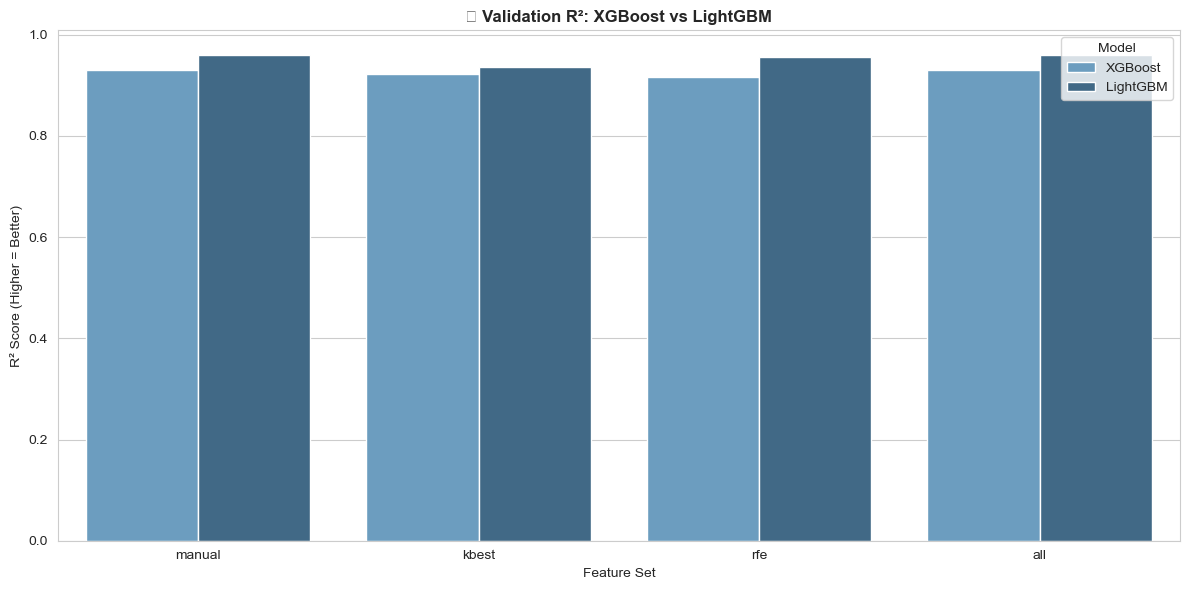

In [41]:
# Set Style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(12, 6))

# Prepare data
r2_data = comparison_df[['Feature_Set', 'XGB_Val_R2', 'LGBM_Val_R2']]
r2_melted = r2_data.melt(id_vars='Feature_Set', var_name='Model', value_name='Validation_R2')
r2_melted['Model'] = r2_melted['Model'].replace({'XGB_Val_R2': 'XGBoost', 'LGBM_Val_R2': 'LightGBM'})

# Plot
sns.barplot(data=r2_melted, x='Feature_Set', y='Validation_R2', hue='Model', palette='Blues_d')
plt.title('🔍 Validation R²: XGBoost vs LightGBM', fontweight='bold')
plt.ylabel('R² Score (Higher = Better)')
plt.xlabel('Feature Set')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

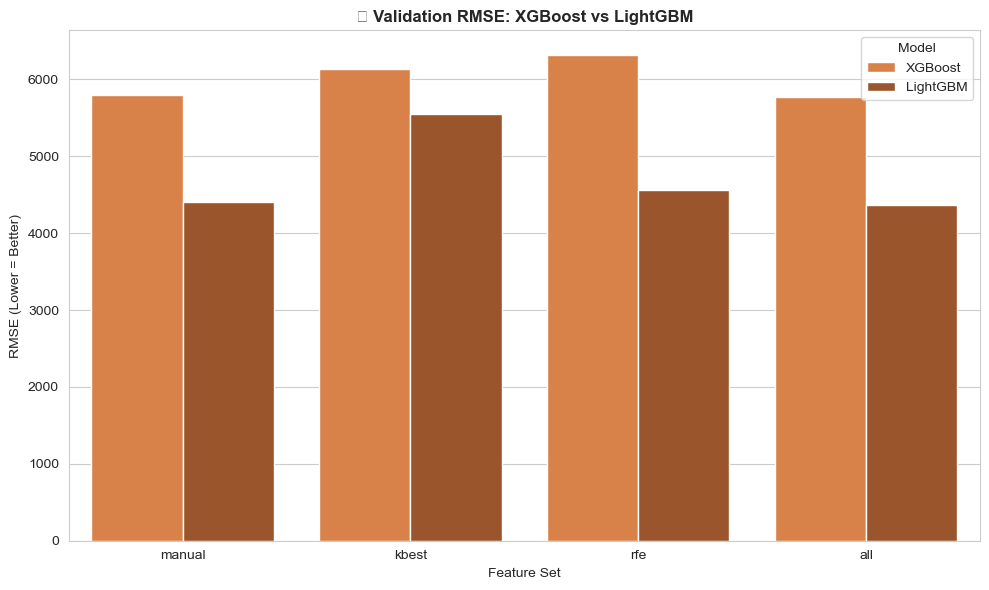

In [42]:
plt.figure(figsize=(10, 6))

# Prepare data
rmse_data = comparison_df[['Feature_Set', 'XGB_Val_RMSE', 'LGBM_Val_RMSE']]
rmse_melted = rmse_data.melt(id_vars='Feature_Set', var_name='Model', value_name='Validation_RMSE')
rmse_melted['Model'] = rmse_melted['Model'].replace({'XGB_Val_RMSE': 'XGBoost', 'LGBM_Val_RMSE': 'LightGBM'})

# Plot
sns.barplot(data=rmse_melted, x='Feature_Set', y='Validation_RMSE', hue='Model', palette='Oranges_d')
plt.title('📉 Validation RMSE: XGBoost vs LightGBM', fontweight='bold')
plt.ylabel('RMSE (Lower = Better)')
plt.xlabel('Feature Set')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [44]:
print("🏆 Model Comparison Summary (Validation Performance)")
summary = comparison_df[[
    'Feature_Set', 
    'XGB_Val_R2', 'LGBM_Val_R2', 
    'XGB_Val_RMSE', 'LGBM_Val_RMSE', 
    'XGB_R2_Drop', 'LGBM_R2_Drop'
]].round(4)

# Rename for clean print
summary.columns = [
    'Feature Set',
    'XGB Val R²', 'LGBM Val R²',
    'XGB Val RMSE', 'LGBM Val RMSE',
    'XGB R² Drop', 'LGBM R² Drop'
]
print(summary.to_string(index=False))

🏆 Model Comparison Summary (Validation Performance)
Feature Set  XGB Val R²  LGBM Val R²  XGB Val RMSE  LGBM Val RMSE  XGB R² Drop  LGBM R² Drop
     manual      0.9301       0.9597       5804.13      4406.4842      -0.0085        0.0077
      kbest      0.9217       0.9362       6139.64      5544.4072      -0.0262        0.0015
        rfe      0.9170       0.9567       6321.51      4568.0207      -0.0144        0.0065
        all      0.9309       0.9603       5769.54      4371.4265      -0.0107        0.0088
